# Simen Nesland (2099685) - Erasmus student (Statistics)

In [ ]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')
nb_path = '/content/notebooks'
os.symlink('/content/drive/My Drive/Colab Notebooks', nb_path)
sys.path.insert(0,nb_path)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import gdown
import numpy as np
import seaborn as sns
import wordcloud
from collections import Counter
import re

## Domain and dataset

For the RAG project I have chosen to look into the world of food. The motivation for this is self experience with odd combinations of ingredients when asking for example ChatGPT for recipes. There are also sevral people reporting similar issues online (https://www.reddit.com/r/cookingforbeginners/comments/147jc5e/psa_do_not_ever_use_chatgpt_to_generate_recipes/) .

I found a dataset online (https://www.kaggle.com/datasets/irkaal/foodcom-recipes-and-reviews) that includes names of dishes, ingredients, recipes and reviews. The idea was the reviews could be useful in sentiment analysis (for example asking for opinions like "Is sushi any good?") and the recipes with ingredients would prevent the LLM (chatbot) from providing not good or potentially harmful recipes.


### Data collection and preprocessing

We start by collecting the data from csv's online. Also note that we downsample in order to get manageable runtimes. We set 10'000 here but when dropping NaN-values this will be reduced to approximately half. Originally there were ~500'000 recipes.

In [ ]:
%pip install langchain
%pip install -U langchain-community

In [ ]:
# Collect data
recipes_url = 'https://drive.google.com/uc?id=1Iz5MpIOTZjidQCHg91nVAPGDsec-o5rI'
recipes_file = 'recipes.csv'
gdown.download(recipes_url, recipes_file, quiet=False)

# Downsample for runtime reasons and select only relevant columns
recipes = pd.read_csv("recipes.csv")
recipes = recipes.sample(n=10000, random_state=66)
recipes = recipes[['RecipeId', 'Name', 'RecipeIngredientParts']]
recipes.to_csv('recipes_sample.csv', index=False)

Downloading...
From (original): https://drive.google.com/uc?id=1Iz5MpIOTZjidQCHg91nVAPGDsec-o5rI
From (redirected): https://drive.google.com/uc?id=1Iz5MpIOTZjidQCHg91nVAPGDsec-o5rI&confirm=t&uuid=f1945c43-e4ca-4eb4-be31-a7823991a1d0
To: /content/recipes.csv
100%|██████████| 704M/704M [00:13<00:00, 50.7MB/s]


The recipes and reviews were in different csv's so we join them at `RecipeId`. When there are multiple reviews for one recipe (which is mostly the case) we concatenate them to one long review (separated by 'Review x:'). We cut the 'combined review length' at 30'000 characters to prevent overflow when loading the csv.

In [ ]:
# Collect data
reviews_url = 'https://drive.google.com/uc?id=1urenX-WDkhG4M_aHNCoykNljaiVKRjOs'
reviews_file = 'reviews.csv'
gdown.download(reviews_url, reviews_file, quiet=False)

# Select only relevant columns and delete all reviews that belong to recipes not in the downsampled dataset
reviews = pd.read_csv('reviews.csv')
reviews = reviews[['RecipeId', 'Review']]
reviews = reviews[reviews['RecipeId'].isin(recipes['RecipeId'])]
reviews = reviews.dropna()
reviews.to_csv('reviews_sample.csv', index=False)

# Combine reviews for each recipe, making sure the combined review is no longer than 2'000 characters
combined_reviews = reviews.groupby('RecipeId')['Review'].apply(lambda x: 'Review ' + ' '.join(x)).reset_index()
combined_reviews = combined_reviews[combined_reviews['Review'].str.len() <= 2000]

# Merge with recipes dataframe to get the full dataset
final_df = pd.merge(recipes, combined_reviews, on='RecipeId', how='left')
final_df = final_df.drop('RecipeId', axis=1)
final_df = final_df.reindex(columns=['Name', 'RecipeIngredientParts','Review'])

# Store new csv
final_df = final_df.dropna(subset=['Review'])
final_df.to_csv('recipes_reviews.csv', index=False)

Downloading...
From (original): https://drive.google.com/uc?id=1urenX-WDkhG4M_aHNCoykNljaiVKRjOs
From (redirected): https://drive.google.com/uc?id=1urenX-WDkhG4M_aHNCoykNljaiVKRjOs&confirm=t&uuid=7a615c6c-2d16-48bb-8f0b-257a8fd044ca
To: /content/reviews.csv
100%|██████████| 496M/496M [00:08<00:00, 58.7MB/s]


### Descriptive analysis

Now that we have collected and organized the data, let us get an overview of it.

#### Recipes

We first look at how many unique recipe names there are.

In [ ]:
# Number of unique recipes
num_recipes = final_df['Name'].nunique()
print(f'Number of unique recipes: {num_recipes}')

Number of unique recipes: 4378


#### Reviews

Let us dive into the reviews since these will be very important for our RAG model. We first look at the distribution of the reviews for each recipe.

Number of recipes with no reviews: 0
Average number of reviews per recipe: 5.356674382716049
Median number of reviews per recipe: 2.0
Maximum number of reviews per recipe: 1228


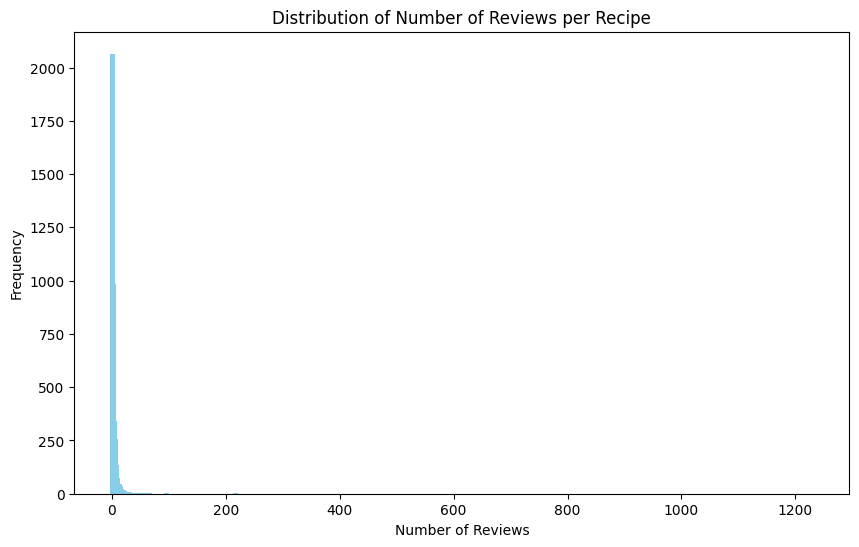

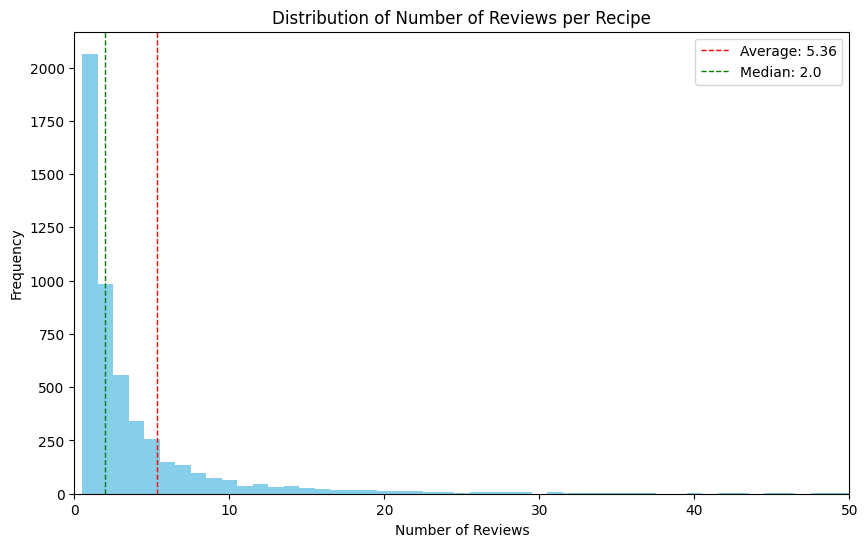

In [ ]:
# Load file
reviews_df = pd.read_csv('reviews_sample.csv')

# Look at statistics
avg_reviews_per_recipe = reviews_df.groupby('RecipeId')['Review'].count().mean()
median_reviews_per_recipe = reviews_df.groupby('RecipeId')['Review'].count().median()
max_reviews_per_recipe = reviews_df.groupby('RecipeId')['Review'].count().max()
recipes_with_no_reviews = final_df['Review'].isnull().sum()
print(f'Number of recipes with no reviews: {recipes_with_no_reviews}')
print(f'Average number of reviews per recipe: {avg_reviews_per_recipe}')
print(f'Median number of reviews per recipe: {median_reviews_per_recipe}')
print(f'Maximum number of reviews per recipe: {max_reviews_per_recipe}')

# Create distribution plots
reviews_df.sort_values('RecipeId', inplace=True)
reviews_count = reviews_df['RecipeId'].value_counts().reset_index(drop=True)
reviews_count = reviews_count.value_counts()

for binwidth in (10, 1):
    plt.figure(figsize=(10, 6))
    ax = plt.bar(reviews_count.index, reviews_count.values, width=binwidth, color='skyblue')

    if binwidth == 1:
        plt.xlim(right=50, left=0)
        plt.axvline(avg_reviews_per_recipe, color='red', linestyle='dashed', linewidth=1)
        plt.axvline(median_reviews_per_recipe, color='green', linestyle='dashed', linewidth=1)
        plt.legend([f'Average: {avg_reviews_per_recipe:.2f}', f'Median: {median_reviews_per_recipe}'])

    plt.title('Distribution of Number of Reviews per Recipe')
    plt.xlabel('Number of Reviews')
    plt.ylabel('Frequency')
    plt.show()

Unsurprisingly, there are no recipes with zero reviews (since we removed them). Most recipes have one or two reviews, while the mean $5.36$ since a few (for example the one with $1228$) drags the average upwards. To get an idea of how long the reviews generally are, we look at the distribution by making a histogram.

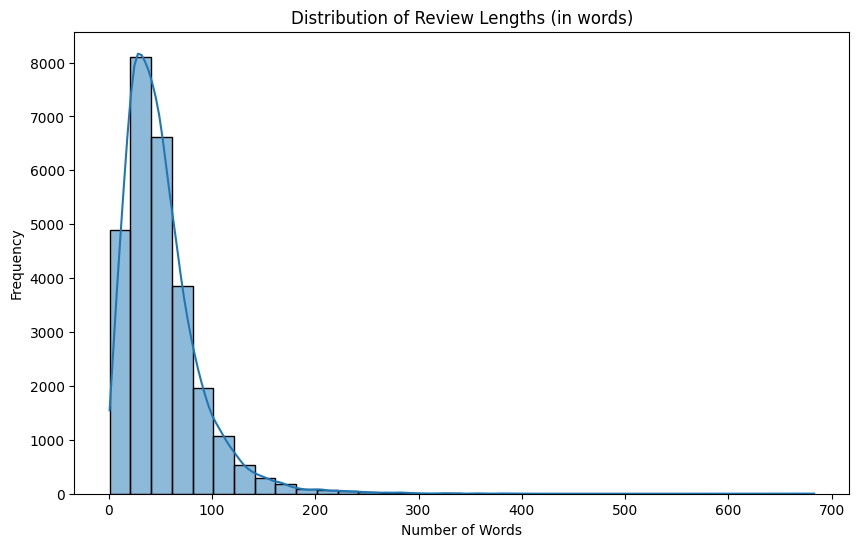

In [ ]:
# Review length distribution
reviews_df['ReviewLength'] = reviews_df['Review'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
sns.histplot(reviews_df['ReviewLength'], binwidth=20, kde=True)
plt.title('Distribution of Review Lengths (in words)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

We see that most of the reviews are $0$ to $80$ words, but there are also quite a few wordy ones of $100$ or more words.

#### Ingredients

We create a few barplots to get a general overview of the ingredients in the recipes. These can be important for the document retrieval in prompts where people provide what ingredients they have or want to include.

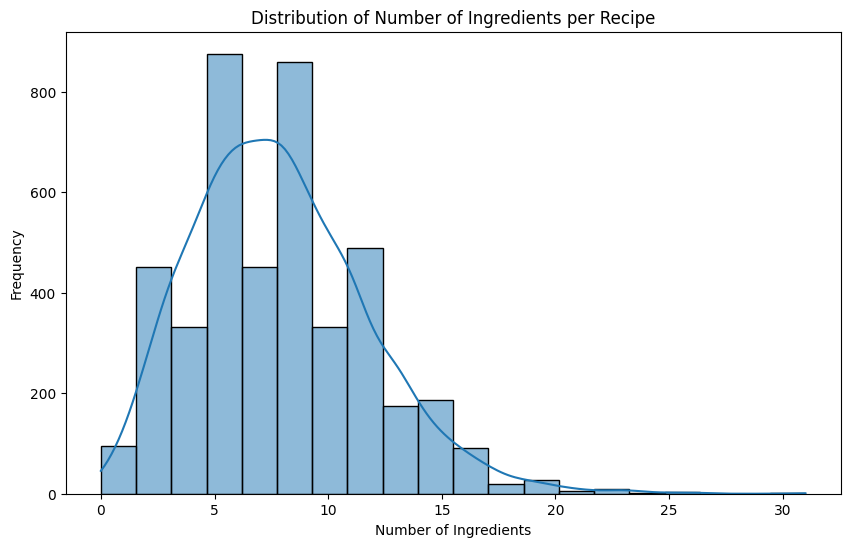

In [ ]:
def parse_r_list(r_list_str):
    # Use regex to extract items inside the R-list string
    return re.findall(r'"(.*?)"', r_list_str)

final_df['NumIngredients'] = final_df['RecipeIngredientParts'].apply(lambda x: len(parse_r_list(x)))
plt.figure(figsize=(10, 6))
sns.histplot(final_df['NumIngredients'], bins=20, kde=True)
plt.title('Distribution of Number of Ingredients per Recipe')
plt.xlabel('Number of Ingredients')
plt.ylabel('Frequency')
plt.show()

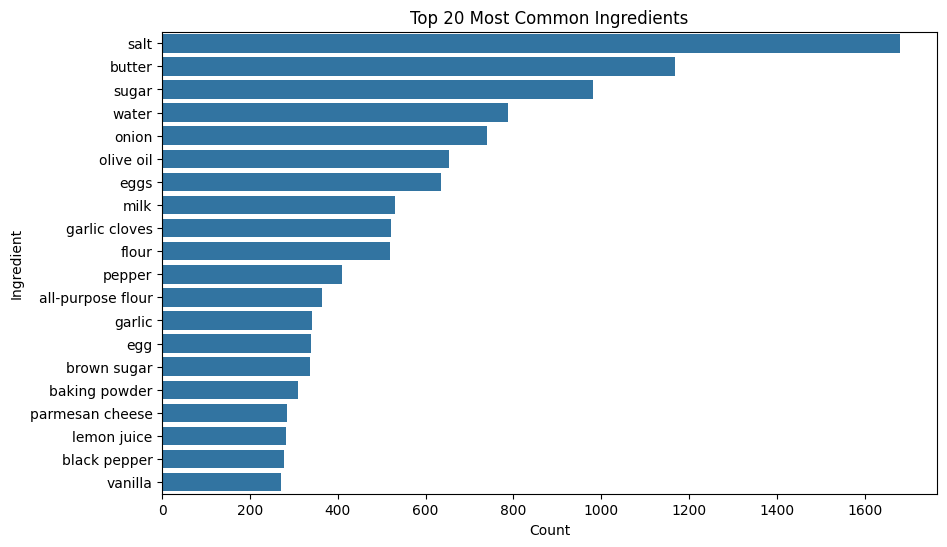

In [ ]:
# Most common ingredients
all_ingredients = []
for ingredients in final_df['RecipeIngredientParts']:
    all_ingredients.extend(parse_r_list(ingredients))

ingredient_counts = Counter(all_ingredients)
common_ingredients = ingredient_counts.most_common(20)
ingredients, counts = zip(*common_ingredients)

plt.figure(figsize=(10, 6))
sns.barplot(x=list(counts), y=list(ingredients))
plt.title('Top 20 Most Common Ingredients')
plt.xlabel('Count')
plt.ylabel('Ingredient')
plt.show()

## Sentence embedder and vector store

To find the most relevant documents in the dataset we must first use a sentence embedder to embed the documents and the query. We initialize a HuggingFace embeddings model using the `HuggingFaceEmbeddings` class from `langchain_huggingface`. The specific model we use is 'sentence-transformers/all-MiniLM-L6-v2' (https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2), which is one of the most widely used sentece transformers online.

To improve efficiency, we wrap this core embeddings model with a cache using `CacheBackedEmbeddings.from_bytes_store`. This ensures that once an embedding is computed, it is stored and reused, which speeds up the process.

For the vector store, we use FAISS (Facebook AI Similarity Search, https://python.langchain.com/v0.1/docs/integrations/vectorstores/faiss/), a library for efficient similarity search and clustering of dense vectors. The `FAISS.from_documents` method creates a vector store from the document embeddings.

We start by loading the preprocessed CSV using the `CSVLoader` form langchain.

In [ ]:
from langchain.document_loaders.csv_loader import CSVLoader

# print current directory
data_loader = CSVLoader(file_path="recipes_reviews.csv", source_column="Name", encoding="utf-8")
docs = data_loader.load()

In [ ]:
%pip install -q -U faiss-cpu tiktoken sentence-transformers
%pip install -U langchain-huggingface

In [ ]:
# Importing necessary libraries for embeddings, vector store, and LLM quantization
from langchain.embeddings import CacheBackedEmbeddings
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.storage import LocalFileStore

# Setting up a local file store to cache embeddings
store = LocalFileStore("./cache/")

# HuggingFace model for sentence embeddings
embed_model_id = 'sentence-transformers/all-MiniLM-L6-v2'

# Initializing the HuggingFace embeddings model
core_embeddings_model = HuggingFaceEmbeddings(
    model_name=embed_model_id
)

# Wrapping the embeddings model with cache to improve efficiency
embedder = CacheBackedEmbeddings.from_bytes_store(
    core_embeddings_model, store, namespace=embed_model_id
)

# Using FAISS to create a vector store from documents
vector_store = FAISS.from_documents(docs, embedder)

Let us test the vector store by creating an example query and see what documents are provided. For this example we try "I have chicken and i want something simple and juicy to make.". The idea is to see if we get recipes where chicken is an ingredient, also if maybe some of the reviews mention that the food was juicy and or simple.

In [ ]:
query = "I have chicken and i want something simple and juicy to make."
embedding_vector = core_embeddings_model.embed_query(query)
docs = vector_store.similarity_search_by_vector(embedding_vector, k = 5)

for page in docs:
  print(page.page_content)
  print('')

Name: Herb Roasted Chicken With Lemon
RecipeIngredientParts: c("chicken", "kosher salt", "black pepper", "fresh herbs", "dried herbs", "lemon", "butter", "chicken broth")
Review: Review This chicken is absolutely amazing. I am always looking for different roasted chicken recipes that are flavorable yet low on carbs and this fits the bill. The aroma of the herbs and lemon while roasting filled the house and the finished product was juicy and tender. Great recipe A moist delicious chicken! A simple recipe to make.  I substituted 1 teaspoon of Schilling salt free All-Purpose Seasoning for the herbs.

Name: Chinese Crock Pot Chicken
RecipeIngredientParts: c("whole chickens", "soy sauce", "orange marmalade", "ketchup", "garlic cloves", "onion")
Review: Review This was so easy and delicious.  It will definitely become a "go to" recipe.  My 6 yr old son helped me throw it all together.  He and my 3 yr old nephew especially enjoyed it. Delicious!! I made this the other night and my husband who

It seems from the example above that the vecor store and similarity search works very well. All recipes include chicken and many of them point out how easy/simple it was to make. Multiple reviews also mention how juicy/moist/tender the result was.

## LLM and quantization

Moving on to LLM quantization, we import additional libraries from torch and transformers. The model we use is 'Meta-Llama-3-8B-Instruct', a large language model from Meta-Llama. This model is state of the art for models of this parameter size. We use the instruct version, which means it is fine tuned as a chat-bot. This makes things a lot easier in our case since we are trying to create a QA-approach.

We use quantization to slightly reduce the precision of the model's parameters, but greatly decreasing the model size and enhancing inference speed. We use the `BitsAndBytes` extension within the `Transformers` library to facilitate this process.

`BitsAndBytesConfig` allows us to specify various parameters for quantization. Here, we configure the model for 4-bit quantization to achieve a significant reduction in memory usage while maintaining good performance.

In [ ]:
%pip install huggingface-hub -q
%pip install bitsandbytes
%pip install ipywidgets
%pip install accelerate

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
import torch
import transformers

model_id = "meta-llama/Meta-Llama-3-8B-Instruct"

bnb_config = transformers.BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16
)

model_config = transformers.AutoConfig.from_pretrained(
    model_id
)

model = transformers.AutoModelForCausalLM.from_pretrained(
    model_id,
    trust_remote_code=True,
    config=model_config,
    quantization_config=bnb_config,
    device_map='auto'
)

model.eval()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): Ll

We get the tokenizer using the `.from_pretrained()` method of the `AutoTokenizer` class. This automatically selects the correct tokenizer based on the model provided (in our case Llama 3, 8B).

In [ ]:
tokenizer = transformers.AutoTokenizer.from_pretrained(
    model_id
)

tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
generate_text = transformers.pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    return_full_text=True,
    temperature=1,
    max_new_tokens=256
)

In [ ]:
from langchain.llms import HuggingFacePipeline

llm = HuggingFacePipeline(pipeline=generate_text)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 0.3. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFacePipeline`.
  warn_deprecated(


In [ ]:
retriever = vector_store.as_retriever()

In [ ]:
from langchain.prompts import PromptTemplate
from langchain import PromptTemplate, LLMChain

In [ ]:
def get_prompt(query: str, context: str) -> str:
  custom_prompt = f"""Answer the questions generally, don't say YOUR opinion.
  Use the dishes with reviews provided below to answer the question.

Dishes with reviews:
{context}

Question: {query}

Pretend I can't see the dishes and reviews.
You may cite them but then you must say you found some reviews on food.com and mention what the dishes were.
"""


  return custom_prompt

In [ ]:
def main():
  query = input("Write: ")

  embedding_vector = core_embeddings_model.embed_query(query)
  docs = vector_store.similarity_search_by_vector(embedding_vector, k = 5)
  output = "\n"
  for doc in docs:
    output += doc.page_content
    output += "\n\n"

  prompt = get_prompt(query, output)

  print(llm.invoke(prompt).strip())

main()

Write: How long should i cook chicken?


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer the questions generally, don't say YOUR opinion.
  Use the dishes with reviews provided below to answer the question.

Dishes with reviews:

Name: Chicken Pepperoni Delight
RecipeIngredientParts: c("boneless skinless chicken breasts", "mozzarella cheese", "oregano", "basil", "pepper")
Review: Review I did this the lazy way.  I bought thin sliced chicken breasts from the butcher, stuffed them as directed, then just folded them over, piled them in the crockpot, poured the sauce over and let it go.  Delicious.  I did not use the meat tenderizer. Very good.  I made these up the night before, put it in a deep glass pie plate in the fridge, and then baked the dish after work.  Everything was done after about 45 mintues (my chicken was fairly thin)-- I think baking it an hour and a half would have turned it into charcoal!   I subbed tomato sauce and added additional seasonings to it because I didn't have any spaghetti sauce... it was a little thin, but it worked.  I skipped the meat te